In [ ]:
!pip install catboost

In [ ]:
!pip install git+https://github.com/gmihaila/ml_things

In [5]:
import os
import json
import jsonlines
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sw = stopwords.words('russian')

from ml_things import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /Users/vova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/train.jsonl -o data/train.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/val.jsonl -o data/val.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/test.jsonl -o data/test.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2861k  100 2861k    0     0  3532k      0 --:--:-- --:--:-- --:--:-- 3528k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  553k  100  553k    0     0  1315k      0 --:--:-- --:--:-- --:--:-- 1315k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1698k  100 1698k    0     0  1734k      0 --:--:-- --:--:-- --:--:-- 1733k


# Open training data

In [3]:
train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

In [45]:
for folder in tqdm(os.listdir('data/')):
    if folder[:3] != 'df_' or folder[-3:] == 'zip':
        continue
    
    train_temp = pd.read_csv(f'data/{folder}/train.csv')
    val_temp = pd.read_csv(f'data/{folder}/val.csv')
    test_temp = pd.read_csv(f'data/{folder}/test.csv')
    try:
        train[folder[3:]] = train_temp.pred
        val[folder[3:]] = val_temp.pred
        test[folder[3:]] = test_temp.pred
    except:
        pass

train['len1'] = [len(elem.split('[SEP]')[0]) for elem in train_temp.text]
val['len1'] = [len(elem.split('[SEP]')[0]) for elem in val_temp.text]
test['len1'] = [len(elem.split('[SEP]')[0]) for elem in test_temp.text]

train['len2'] = [len(elem.split('[SEP]')[1]) for elem in train_temp.text]
val['len2'] = [len(elem.split('[SEP]')[1]) for elem in val_temp.text]
test['len2'] = [len(elem.split('[SEP]')[1]) for elem in test_temp.text]

train['labels'] = train_temp.labels
val['labels'] = val_temp.labels
test['labels'] = test_temp.labels

100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


# Add cosine-similarity

In [7]:
def cosine(s1, s2):
    s1 = [morph.parse(w)[0].normal_form for w in word_tokenize(s1)]
    s2 = [morph.parse(w)[0].normal_form for w in word_tokenize(s2)]
    
    l1 = []
    l2 = []
    
    s1 = {w for w in s1 if not w in sw}
    s2 = {w for w in s2 if not w in sw}
    
    rvector = s1.union(s2)  
    
    for w in rvector: 
        if w in s1: 
            l1.append(1)
        else: 
            l1.append(0) 
        if w in s2: 
            l2.append(1) 
        else: 
            l2.append(0) 
            
    c = 0
    for i in range(len(rvector)): 
        c += l1[i] * l2[i]
    return c / float((sum(l1) * sum(l2)) ** 0.5) 
    
def get_cosine(path):
    """
    Args:
        path (string): Path to jsonl file
    """
    data = []
    with open(path, 'r') as json_file:
        json_list = list(json_file)
        for json_str in tqdm(json_list):
            item = json.loads(json_str)
            text = re.sub(r'\(\d+\)', "", item['passage']['text']).replace('"', '')
            questions = item['passage']['questions']
            for q in questions:
                question = q['question']
                ans = q['answers']
                for a in ans:
                    data.append(cosine(a["text"], text))
#                     print(data[-1], '-', a["text"], text)
    
    return data

In [8]:
train['cosine'] = get_cosine('data/train.jsonl')
val['cosine'] = get_cosine('data/val.jsonl')
test['cosine'] = get_cosine('data/test.jsonl')

100%|██████████| 322/322 [09:07<00:00,  1.70s/it]


# Result dfs

In [72]:
train

,labels,cosine,distilbert-base-multilingual-cased,bert-base-multilingual-cased,sentence-RuBERT,RuBERT,bert-base-multilingual-uncased,bert-base-multilingual-cased 3,bert-base-multilingual-cased 2,albert-base-v2,len1,len2
0,1,0.139347,1,1,1,0,1,1,1,0,1096,28
1,0,0.069673,0,0,0,0,0,0,0,0,1096,27
2,0,0.056888,0,0,0,0,0,0,0,0,1096,35
3,1,0.069673,1,0,0,0,0,0,1,0,1096,49
4,0,0.069673,0,0,0,0,0,0,0,0,1096,45
...,...,...,...,...,...,...,...,...,...,...,...,...
11945,0,0.172133,0,0,0,0,0,0,0,0,1249,136
11946,1,0.319142,1,1,1,1,1,1,1,1,1249,198
11947,0,0.172133,0,0,0,0,0,0,0,0,1249,154
11948,0,0.102062,0,0,0,0,0,0,0,1,1249,173


In [47]:
val

,labels,cosine,distilbert-base-multilingual-cased,bert-base-multilingual-cased,sentence-RuBERT,RuBERT,bert-base-multilingual-uncased,bert-base-multilingual-cased 3,bert-base-multilingual-cased 2,albert-base-v2,len1,len2
0,1,0.234404,1,1,1,1,0,1,1,0,988,85
1,0,0.181568,0,1,0,0,0,0,0,0,988,72
2,0,0.157243,0,0,0,0,0,0,0,1,988,84
3,0,0.296500,1,1,1,1,1,1,1,1,988,108
4,1,0.296500,1,1,1,1,1,1,1,1,988,116
...,...,...,...,...,...,...,...,...,...,...,...,...
2230,0,0.071429,0,0,0,1,0,0,1,0,1241,47
2231,0,0.123718,0,0,0,0,0,0,0,0,1241,79
2232,1,0.202031,1,1,1,1,1,1,1,0,1241,61
2233,1,0.206197,1,1,1,1,1,1,1,0,1241,75


In [48]:
test

,labels,cosine,distilbert-base-multilingual-cased,bert-base-multilingual-cased,sentence-RuBERT,RuBERT,bert-base-multilingual-uncased,bert-base-multilingual-cased 3,bert-base-multilingual-cased 2,albert-base-v2,len1,len2
0,NaN,0.139272,0,0,0,0,0,0,0,0,1382,53
1,NaN,0.189525,1,0,0,0,0,0,0,0,1382,66
2,NaN,0.196960,0,0,1,0,1,1,0,1,1382,88
3,NaN,0.278543,1,1,1,1,1,1,1,1,1382,100
4,NaN,0.107211,0,0,0,0,0,0,0,0,1382,66
...,...,...,...,...,...,...,...,...,...,...,...,...
7609,NaN,0.158114,0,1,0,0,1,1,1,0,1421,56
7610,NaN,0.136931,0,0,0,0,0,0,0,0,1421,76
7611,NaN,0.052705,0,0,0,0,0,0,0,0,1421,78
7612,NaN,0.091287,0,0,0,0,0,0,0,0,1421,78


In [49]:
!mkdir data/df_cosine/

train.to_csv('data/df_cosine/train.scv')
val.to_csv('data/df_cosine/val.scv')
test.to_csv('data/df_cosine/test.scv')

mkdir: data/df_cosine/: File exists


# Modeling

## Setup model

In [65]:
model = CatBoostClassifier(
                            learning_rate=1e-2,
                            max_depth=4,
                            iterations=1000,
                            loss_function="MultiClass",
                            eval_metric='MultiClass',
                            random_seed=179,
                            class_weights=[55, 45],
#                            task_type='GPU'
                          )

## Train model

In [66]:
model.fit(train.drop(['labels'], axis=1),
          train.labels,
          verbose=True,
          eval_set=(val.drop(['labels'], axis=1), val.labels),
#           plot=True,
         )

0:	learn: 0.6841436	test: 0.6876411	best: 0.6876411 (0)	total: 9.85ms	remaining: 9.84s
1:	learn: 0.6752679	test: 0.6822960	best: 0.6822960 (1)	total: 33.8ms	remaining: 16.9s
2:	learn: 0.6666160	test: 0.6770646	best: 0.6770646 (2)	total: 39.1ms	remaining: 13s
3:	learn: 0.6581525	test: 0.6719509	best: 0.6719509 (3)	total: 54ms	remaining: 13.4s
4:	learn: 0.6516483	test: 0.6681481	best: 0.6681481 (4)	total: 58.7ms	remaining: 11.7s
5:	learn: 0.6434016	test: 0.6632752	best: 0.6632752 (5)	total: 62ms	remaining: 10.3s
6:	learn: 0.6353623	test: 0.6585119	best: 0.6585119 (6)	total: 65.8ms	remaining: 9.34s
7:	learn: 0.6274754	test: 0.6538781	best: 0.6538781 (7)	total: 69.3ms	remaining: 8.59s
8:	learn: 0.6196874	test: 0.6494233	best: 0.6494233 (8)	total: 71.9ms	remaining: 7.92s
9:	learn: 0.6120730	test: 0.6450054	best: 0.6450054 (9)	total: 74.4ms	remaining: 7.36s
10:	learn: 0.6046085	test: 0.6407090	best: 0.6407090 (10)	total: 77ms	remaining: 6.93s
11:	learn: 0.5972846	test: 0.6365164	best: 0.6365

In [67]:
list(zip(train.drop(['labels'], 1).columns, model.get_feature_importance()))

[('cosine', 0.09519613123507298),
 ('distilbert-base-multilingual-cased', 0.564166523086102),
 ('bert-base-multilingual-cased', 4.921304959014167),
 ('sentence-RuBERT', 0.043196300457079),
 ('RuBERT', 0.03525015222542399),
 ('bert-base-multilingual-uncased', 0.02643394912022888),
 ('bert-base-multilingual-cased 3', 0.04022900374475356),
 ('bert-base-multilingual-cased 2', 93.94161757327596),
 ('albert-base-v2', 0.0019552742263818684),
 ('len1', 0.28568272374646886),
 ('len2', 0.04496740986836175)]

## Validate on val_df

In [68]:
val_pred = model.predict(val.drop(['labels'], axis=1))

In [69]:
print("Precision: {0:6.2f}".format(precision_score(val.labels, val_pred, average='macro', zero_division=0)))
print("Recall: {0:6.2f}".format(recall_score(val.labels, val_pred, average='macro', zero_division=0)))
print("F1-measure: {0:6.2f}".format(f1_score(val.labels, val_pred, average='macro', zero_division=0)))
print("Accuracy: {0:6.2f}".format(accuracy_score(val.labels, val_pred)))
print()
print(classification_report(val.labels, val_pred, zero_division=0))

Precision:   0.79
Recall:   0.78
F1-measure:   0.78
Accuracy:   0.79

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1242
           1       0.79      0.71      0.75       993

    accuracy                           0.79      2235
   macro avg       0.79      0.78      0.78      2235
weighted avg       0.79      0.79      0.78      2235



Normalized confusion matrix


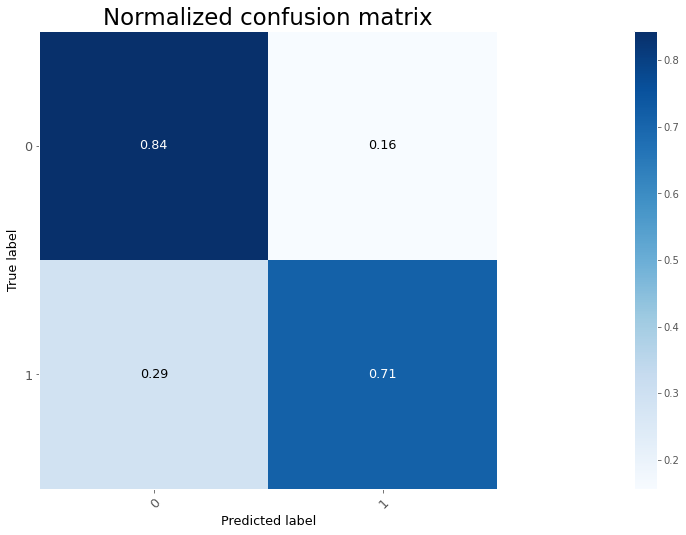

array([[0.84380032, 0.15619968],
       [0.28600201, 0.71399799]])

In [70]:
plot_confusion_matrix(y_true=val.labels, y_pred=val_pred, magnify=.15, normalize=True)

## Predict test_df labels

In [71]:
pred = model.predict_proba(test.drop(['labels'], axis=1))
pred = [elem[0] for elem in pred]
print(pred[:10], '...', pred[-10:])

[0.8340610672905224, 0.8161850803128016, 0.8275835028245424, 0.17059824018168976, 0.8337823729191167, 0.19116905533030465, 0.8338812700717094, 0.16964612637438356, 0.83375897199154, 0.7581244217173886] ... [0.832183729809931, 0.20268599828931794, 0.8337832590390443, 0.8339821699002301, 0.8337633682983607, 0.1914174454536928, 0.833879636841298, 0.8336175628741308, 0.8333828641688154, 0.8010890268596514]


In [57]:
Counter(pred)

Counter({0: 4675, 1: 2939})

# Make submition

In [58]:
def save_pred(filename, preds, model):
    with open('data/test.jsonl', 'r') as json_file:
        test = list(map(lambda x: json.loads(x), list(json_file)))
    ind = 0
    for i in range(len(test)):
        test[i]['passage'].pop("text")
        questions = test[i]['passage']['questions']
        for j in range(len(questions)):
            questions[j].pop("question")
            for k in range(len(questions[j]["answers"])):
                questions[j]["answers"][k] = {"idx": questions[j]["answers"][k]['idx'],
                                              "label": int(preds[ind])}
                ind += 1
    
    !mkdir submitions/
    
    with jsonlines.open("submitions/" + filename, 'w') as file:
        file.write_all(test)
    with open('submitions/info.txt', 'a') as file:
        file.write(f"- File: {filename}\nModel: {model}\n\n\n")

In [59]:
file_name = f'{__import__("datetime").datetime.now()}.jsonl'
save_pred(file_name, pred, str(model))

mkdir: submitions/: File exists
